<a href="https://colab.research.google.com/github/carol-furtado/Denoising-and-image-classification/blob/main/Image_Denoising_%26_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

In [3]:
from google.colab import files
uploaded = files.upload()


Saving train.zip to train (1).zip


In [5]:
import zipfile

with zipfile.ZipFile("train.zip", 'r') as zip_ref:
    zip_ref.extractall("train")


In [6]:
!ls /content


 sample_data   train  'train (1).zip'   train.zip


In [7]:
data_dir_clean = "/content/train/train/clean"
data_dir_noisy = "/content/train/train/noisy"
normalization_layer = tf.keras.layers.Rescaling(1./255)

clean = tf.keras.utils.image_dataset_from_directory(
    data_dir_clean,
    labels=None,

    image_size=(224,224),
    batch_size=32,
    shuffle=False
).map(lambda x: (normalization_layer(x)))


noisy = tf.keras.utils.image_dataset_from_directory(
    data_dir_noisy,
    labels=None,

    image_size=(224,224),
    batch_size=32,
    shuffle=False
).map(lambda x: (normalization_layer(x)))


Found 1795 files.
Found 1795 files.


In [8]:
import numpy as np

# Convert TF dataset to numpy array (no labels since label_mode=None)
def dataset_to_numpy(dataset):
    images = []
    for batch in dataset:
        images.append(batch.numpy())   # each batch is a tensor of shape (batch_size, h, w, c)
    return np.concatenate(images, axis=0)

# Example
clean_train_images = dataset_to_numpy(clean)
noisy_train_images = dataset_to_numpy(noisy)

print(clean_train_images.shape)
print(noisy_train_images.shape)


(1795, 224, 224, 3)
(1795, 224, 224, 3)


In [19]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_unet_autoencoder(input_shape=(224,224,3), latent_dim=256):
    inputs = layers.Input(shape=input_shape)

    # ---- Encoder ----
    e1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    e1 = layers.Conv2D(32, 3, activation='relu', padding='same')(e1)
    p1 = layers.MaxPooling2D((2,2))(e1)

    e2 = layers.Conv2D(64, 3, activation='relu', padding='same')(p1)
    e2 = layers.Conv2D(64, 3, activation='relu', padding='same')(e2)
    p2 = layers.MaxPooling2D((2,2))(e2)

    e3 = layers.Conv2D(128, 3, activation='relu', padding='same')(p2)
    e3 = layers.Conv2D(128, 3, activation='relu', padding='same')(e3)
    p3 = layers.MaxPooling2D((2,2))(e3)

    e4 = layers.Conv2D(256, 3, activation='relu', padding='same')(p3)
    e4 = layers.Conv2D(256, 3, activation='relu', padding='same')(e4)
    p4 = layers.MaxPooling2D((2,2))(e4)

    # Bottleneck
    b = layers.Conv2D(512, 3, activation='relu', padding='same')(p4)

    # ---- Decoder ----
    d4 = layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu')(b)
    d4 = layers.concatenate([d4, e4])  # skip connection
    d4 = layers.Conv2D(256, 3, activation='relu', padding='same')(d4)

    d3 = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(d4)
    d3 = layers.concatenate([d3, e3])
    d3 = layers.Conv2D(128, 3, activation='relu', padding='same')(d3)

    d2 = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(d3)
    d2 = layers.concatenate([d2, e2])
    d2 = layers.Conv2D(64, 3, activation='relu', padding='same')(d2)

    d1 = layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu')(d2)
    d1 = layers.concatenate([d1, e1])
    d1 = layers.Conv2D(32, 3, activation='relu', padding='same')(d1)

    outputs = layers.Conv2D(3, 1, activation='sigmoid')(d1)

    return Model(inputs, outputs, name="UNet_Autoencoder")

autoencoder = build_unet_autoencoder()



In [20]:

import tensorflow.image as tfi

def psnr_metric(y_true, y_pred):
    return tfi.psnr(y_true, y_pred, max_val=1.0)

def ssim_metric(y_true, y_pred):
    return tfi.ssim(y_true, y_pred, max_val=1.0)


In [21]:

#compile

autoencoder = DenoisingAutoencoder()
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
                    loss=tf.keras.losses.MeanAbsoluteError(),
                    metrics=[psnr_metric, ssim_metric])



In [1]:
history = autoencoder.fit(
    x=tf.convert_to_tensor(noisy_train_images, dtype=tf.float32),
    y=tf.convert_to_tensor(clean_train_images, dtype=tf.float32),
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    shuffle=True
)

NameError: name 'autoencoder' is not defined

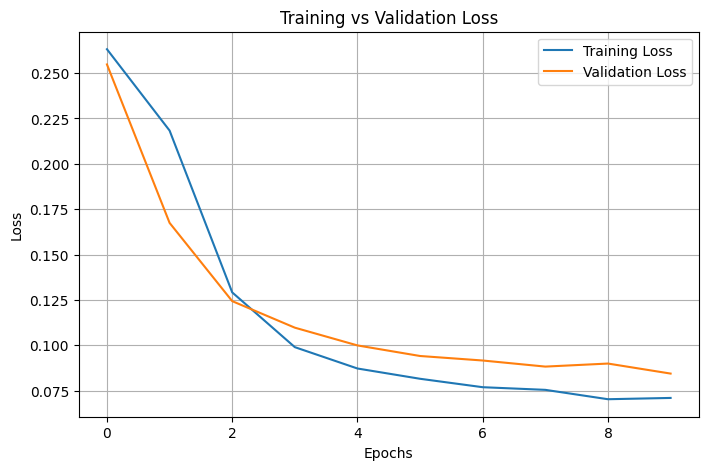

In [13]:
#plotting training vs validation loss
plt.figure(figsize=(8,5))

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
#now im gonna load test images dataset to evaluate model performance
from google.colab import files
uploaded = files.upload()


Saving test.zip to test.zip


In [15]:
import zipfile

with zipfile.ZipFile("test.zip", 'r') as zip_ref:
    zip_ref.extractall("test")


In [16]:
test_dir = "/content/test/test/noisy"
normalization_layer = tf.keras.layers.Rescaling(1./255)


# Load noisy test images
noisy_test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels=None,              # No labels, just images
    image_size=(224, 224),      # 👈 change to your image size
    color_mode="rgb",   # or "rgb" if your dataset is in color
    batch_size=32,
    shuffle=False             # keep order consistent
).map(lambda x: (normalization_layer(x)))

# Convert dataset to numpy array
def dataset_to_numpy(dataset):
    images = []
    for batch in dataset:
        images.extend(batch.numpy())
    return np.array(images)

noisy_test_images = dataset_to_numpy(noisy_test_ds)


Found 772 files.


25/25 ━━━━━━━━━━━━━━━━━━━━ 227s 9s/step


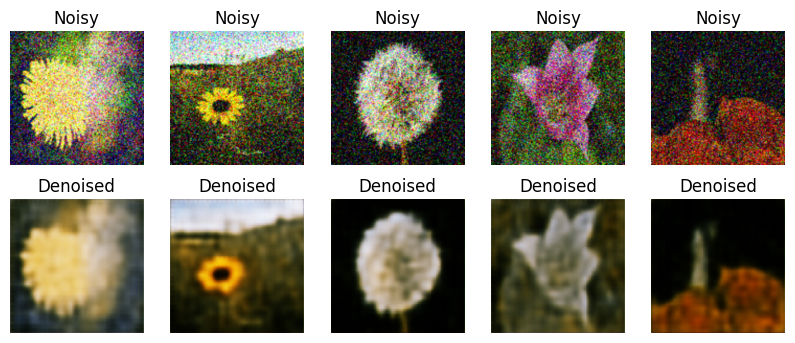

In [17]:
# Predict denoised images from noisy test set
denoised_test_images = autoencoder.predict(noisy_test_images)

import matplotlib.pyplot as plt
import numpy as np



n = 5  # number of samples to visualize
plt.figure(figsize=(10, 4))

for i in range(n):
    # Noisy input
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(noisy_test_images[i])
    plt.title("Noisy")
    plt.axis("off")

    # Denoised output
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(denoised_test_images[i])
    plt.title("Denoised")
    plt.axis("off")

plt.show()
